In [1]:
%load_ext autoreload
%autoreload 2
import sys,os
sys.path.append('../')   
import numpy as np
import pandas as pd
from model.erroneousPreference import erroneousPreference
from model.erroneousChoice_full import erroneousChoice
from kernel import jaxrbf, RBF, Linear, LinearRBF
from utility import  paramz
from sklearn.model_selection import train_test_split,GroupShuffleSplit
# for plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

def extract_CA_RA(df,X,cols):
    IndexMat=[]
    IndCh=[]
    CA = []
    RA = []
    for el in np.unique(df.case.values):
        d = df[df.case==el]
        ind=[]
        row=d[cols].values
        #print(row)
        indc=[]
        indm=[]
        for r in range(row.shape[0]):
            #print(repr(rowi))
            #print(np.isin(X, row[r]))
            #print(row[r])
            j = np.where( np.isin(X, row[r]).all(axis=1))[0][0]
            #print(j)
            #print(d['choice'].iloc[r])
            indm.append(j)
            indc.append(d['choice'].iloc[r])
                
        IndexMat.append(indm)
        IndCh.append(indc)
    IndexMat=np.vstack(IndexMat)
    ind=np.argsort(IndexMat,axis=1)
    IndCh=np.vstack(IndCh)
    for i in range(ind.shape[0]):
        IndexMat[i,:]=IndexMat[i,ind[i,:]]
        IndCh[i,:]=IndCh[i,ind[i,:]]
    return IndexMat,IndCh

def make_CA_RA(IndexMat,IndCh):
    CA=[]
    RA=[]
    for c in range(IndexMat.shape[0]):
        indr=IndexMat[c,:]
        chrow=IndCh[c,:]
        indn0=np.where(chrow>0)[0]
        ind0=np.where(chrow==0)[0]
        CA.append(indr[indn0].tolist())
        RA.append(indr[ind0].tolist())
        
    return CA,RA

def make_pref_or_choices(IndexMat,IndCh,typeR='pref', drop_duplicates=False):
    num=IndexMat.shape[1]
    if typeR=='pref':
        
        if drop_duplicates:
            dfm = pd.DataFrame(np.hstack([IndexMat,IndCh])).drop_duplicates()
        else:
            dfm = pd.DataFrame(np.hstack([IndexMat,IndCh]))
        IndexMat=dfm.iloc[:,0:num].values
        IndCh=dfm.iloc[:,num:].values
        CA,RA = make_CA_RA(IndexMat,IndCh)
        
        CA=np.vstack(CA)
        RA = np.vstack(RA)
        All=[]
        for i in range(RA.shape[1]):
            All=All+list(zip(CA[:,0],RA[:,i].tolist()))
        All=np.vstack(All)
        CA=[[All[i,0]] for i in range(All.shape[0])]
        RA=[[All[i,1]] for i in range(All.shape[0])]
        
    elif typeR=='choice':
        dfm = pd.DataFrame(np.hstack([IndexMat,IndCh])).groupby(np.arange(num).tolist()).mean().reset_index()
        IndexMat=dfm.iloc[:,0:num].values
        IndCh=dfm.iloc[:,num:].values
        CA,RA = make_CA_RA(IndexMat,IndCh)
    return CA,RA

In [2]:
df = pd.read_csv("datasets/ModeCanada.csv",index_col=0)
#df.drop(columns=['income','urban','alt'],inplace=True)
cols_cov=['dist', 'cost', 'ivt', 'ovt', 'freq']
#cols_cov=['dist', 'cost', 'ivt', 'ovt', 'freq','income','urban']
num=4
df = df[(df.noalt==num) & (df.urban==1) & ((df.income==70) | (df.income==70))]
print(df.shape)
#print(df.iloc[1000:-1,:].head(16).to_latex(index=False))

(2716, 11)


In [56]:
np.unique(df.income,return_counts=True)

(array([70]), array([2716]))

In [57]:
#print(df[df.case.isin([ 290,  295,  579,  582, 2981, 2982, 3011, 3012, 3044, 3045])].to_latex(index=False))

In [ ]:
n_splits=1
splitter = GroupShuffleSplit(train_size=0.7, n_splits=n_splits, random_state = 1)
split = splitter.split(df, groups=df['case'])
Res=[]
for cv in range(n_splits):
    print(cv)
    ind_train, ind_test = next(split)
    df_train = df.iloc[ind_train,:].reset_index(drop=True)
    df_test  = df.iloc[ind_test,:].reset_index(drop=True)
    X_tr = np.unique(df_train[cols_cov].values,axis=0)
    X_te = np.unique(df_test[cols_cov].values,axis=0)
    
    #extract choices
    typeR='pref' #'pref'
    #train set
    IndexMat,IndCh=extract_CA_RA(df_train,X_tr,cols_cov)
    CA_tr,RA_tr=make_pref_or_choices(IndexMat,IndCh,typeR=typeR)
    #test set
    IndexMat,IndCh=extract_CA_RA(df_test,X_te,cols_cov)
    CA_te,RA_te=make_pref_or_choices(IndexMat,IndCh,typeR=typeR)
    
    #standard scaling
    scalerx=StandardScaler().fit(X_tr)
    X_trasf_tr = scalerx.transform(X_tr)
    X_trasf_te = scalerx.transform(X_te)
    
    # Data dictionary
    data = {}
    data["Pairs"]  = np.hstack([CA_tr,RA_tr])
    data["X"] = X_trasf_tr

    # define kernel and hyperparams
    Kernel = RBF #RBF,Linear
    params={}
    #kernel parameter dictionary
    if Kernel==RBF:
        params={'lengthscale': {'value':1.0*np.ones(data["X"].shape[1],float), 
                                'range':np.vstack([[0.1, 10.0]]*data["X"].shape[1]),
                                'transform': paramz.logexp()},
                     'variance': {'value':np.array([1.0]), 
                                'range':np.vstack([[0.01, 10.0]]),
                                'transform': paramz.logexp()}
                  }
    elif Kernel==Linear:
        params['variance']={'value':0.5+np.random.rand(1,data["X"].shape[1]) ,
                                    'range':np.vstack([[1e-6, 40.0]]*data["X"].shape[1]),
                                    'transform': paramz.logexp()}
    elif Kernel==LinearRBF:
            params={'rbf_lengthscale': {'value':1.0*np.ones(data["X"].shape[1],float), 
                                'range':np.vstack([[0.1, 10.0]]*data["X"].shape[1]),
                                'transform': paramz.logexp()},
                     'rbf_variance': {'value':np.array([1.0]), 
                                'range':np.vstack([[0.01, 10.0]]),
                                'transform': paramz.logexp()},
                    'lin_variance': {'value':1.0*np.ones(data["X"].shape[1],float), 
                                'range':np.vstack([[0.0001, 10.0]]*data["X"].shape[1]),
                                'transform': paramz.logexp()},
                  }

    #define preference model 
    model = erroneousPreference(data,Kernel,params)
    #compute hyperparameters
    model.optimize_hyperparams(num_restarts=1)
    print(model.params)
    
    #sample from posterior
    model.sample(nsamples=1000, tune=100)
    #predicted samples
    predictions = model.predict(X_trasf_te)
    meanu = np.mean(predictions,axis=1)
    Acc = []
    for i in range(len(CA_te)):
        if meanu[CA_te[i]]>np.max(meanu[RA_te[i]]):
            Acc.append(1.0)
        else:
            Acc.append(0.0)
    Res.append(np.mean(Acc))
    print(np.mean(Res))

0


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration 0  -368.99575479713246
{'lengthscale': {'value': array([1.1046301 , 0.58928899, 2.49054933, 1.38796798, 0.55137444]), 'range': array([[ 0.1, 10. ],
       [ 0.1, 10. ],
       [ 0.1, 10. ],
       [ 0.1, 10. ],
       [ 0.1, 10. ]]), 'transform': <utility.paramz.logexp object at 0x7f2414653e80>}, 'variance': {'value': array([5.11743284]), 'range': array([[ 0.01, 10.  ]]), 'transform': <utility.paramz.logexp object at 0x7f2414653b20>}}


  0%|          | 2/1100 [00:00<01:33, 11.80it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  0%|          | 4/1100 [00:00<01:25, 12.76it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  1%|          | 8/1100 [00:00<01:34, 11.54it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  1%|          | 10/1100 [00:00<01:35, 11.44it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  1%|▏         | 14/1100 [00:01<01:37, 11.15it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  1%|▏         | 16/1100 [00:01<01:37, 11.12it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  2%|▏         | 20/1100 [00:01<01:37, 11.03it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  2%|▏         | 22/1100 [00:01<01:36, 11.17it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  2%|▏         | 26/1100 [00:02<01:35, 11.30it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  3%|▎         | 28/1100 [00:02<01:35, 11.25it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  3%|▎         | 32/1100 [00:02<01:33, 11.38it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  3%|▎         | 34/1100 [00:03<01:33, 11.35it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  3%|▎         | 38/1100 [00:03<01:33, 11.35it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  4%|▎         | 40/1100 [00:03<01:33, 11.28it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  4%|▍         | 44/1100 [00:03<01:36, 10.91it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'>

  4%|▍         | 46/1100 [00:04<01:35, 10.98it/s]

 (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  4%|▍         | 48/1100 [00:04<01:34, 11.08it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  5%|▍         | 52/1100 [00:04<01:32, 11.34it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  5%|▍         | 54/1100 [00:04<01:32, 11.31it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  5%|▌         | 58/1100 [00:05<01:36, 10.85it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  5%|▌         | 60/1100 [00:05<01:36, 10.83it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  6%|▌         | 64/1100 [00:05<01:34, 10.96it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  6%|▌         | 66/1100 [00:05<01:34, 10.93it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  6%|▋         | 70/1100 [00:06<01:31, 11.20it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  7%|▋         | 72/1100 [00:06<01:31, 11.24it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  7%|▋         | 76/1100 [00:06<01:28, 11.52it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  7%|▋         | 78/1100 [00:06<01:36, 10.61it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  7%|▋         | 80/1100 [00:07<01:34, 10.79it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  8%|▊         | 84/1100 [00:07<01:30, 11.20it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  8%|▊         | 86/1100 [00:07<01:30, 11.17it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  8%|▊         | 90/1100 [00:08<01:29, 11.27it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  8%|▊         | 92/1100 [00:08<01:28, 11.44it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  9%|▊         | 96/1100 [00:08<01:25, 11.74it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  9%|▉         | 98/1100 [00:08<01:25, 11.76it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  9%|▉         | 102/1100 [00:09<01:22, 12.03it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


  9%|▉         | 104/1100 [00:09<01:23, 11.95it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 10%|▉         | 108/1100 [00:09<01:23, 11.84it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 10%|█         | 110/1100 [00:09<01:24, 11.78it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 10%|█         | 114/1100 [00:10<01:21, 12.04it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 11%|█         | 116/1100 [00:10<01:21, 12.09it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 11%|█         | 120/1100 [00:10<01:22, 11.95it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 11%|█         | 122/1100 [00:10<01:21, 11.99it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 11%|█▏        | 126/1100 [00:11<01:20, 12.13it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 12%|█▏        | 128/1100 [00:11<01:20, 12.10it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 12%|█▏        | 132/1100 [00:11<01:22, 11.80it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 12%|█▏        | 134/1100 [00:11<01:23, 11.61it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 13%|█▎        | 138/1100 [00:12<01:23, 11.56it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 13%|█▎        | 140/1100 [00:12<01:24, 11.38it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 13%|█▎        | 144/1100 [00:12<01:22, 11.65it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 13%|█▎        | 146/1100 [00:12<01:20, 11.85it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 14%|█▎        | 150/1100 [00:13<01:18, 12.10it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 14%|█▍        | 152/1100 [00:13<01:19, 11.92it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 14%|█▍        | 156/1100 [00:13<01:19, 11.83it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 14%|█▍        | 158/1100 [00:13<01:20, 11.70it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 15%|█▍        | 162/1100 [00:14<01:19, 11.85it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 15%|█▍        | 164/1100 [00:14<01:18, 11.96it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 15%|█▌        | 168/1100 [00:14<01:20, 11.59it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 15%|█▌        | 170/1100 [00:14<01:20, 11.52it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 16%|█▌        | 174/1100 [00:15<01:18, 11.77it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 16%|█▌        | 176/1100 [00:15<01:19, 11.64it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 16%|█▋        | 180/1100 [00:15<01:21, 11.35it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 17%|█▋        | 182/1100 [00:15<01:19, 11.51it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 17%|█▋        | 186/1100 [00:16<01:19, 11.53it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 17%|█▋        | 188/1100 [00:16<01:17, 11.70it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 17%|█▋        | 192/1100 [00:16<01:17, 11.68it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 18%|█▊        | 194/1100 [00:16<01:17, 11.68it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 18%|█▊        | 198/1100 [00:17<01:16, 11.76it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 18%|█▊        | 200/1100 [00:17<01:16, 11.76it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 19%|█▊        | 204/1100 [00:17<01:16, 11.67it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 19%|█▊        | 206/1100 [00:17<01:16, 11.65it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 19%|█▉        | 210/1100 [00:18<01:16, 11.68it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 19%|█▉        | 212/1100 [00:18<01:15, 11.73it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 20%|█▉        | 216/1100 [00:18<01:14, 11.82it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 20%|█▉        | 218/1100 [00:18<01:16, 11.51it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 20%|██        | 222/1100 [00:19<01:13, 11.88it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 20%|██        | 224/1100 [00:19<01:13, 11.93it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 21%|██        | 228/1100 [00:19<01:14, 11.69it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 21%|██        | 230/1100 [00:19<01:13, 11.81it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 21%|██▏       | 234/1100 [00:20<01:15, 11.40it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 21%|██▏       | 236/1100 [00:20<01:14, 11.60it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 22%|██▏       | 240/1100 [00:20<01:13, 11.76it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 22%|██▏       | 242/1100 [00:20<01:13, 11.70it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 22%|██▏       | 246/1100 [00:21<01:11, 11.97it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 23%|██▎       | 248/1100 [00:21<01:11, 11.97it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 23%|██▎       | 252/1100 [00:21<01:11, 11.88it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 23%|██▎       | 254/1100 [00:21<01:12, 11.75it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 23%|██▎       | 258/1100 [00:22<01:10, 11.99it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 24%|██▎       | 260/1100 [00:22<01:09, 12.01it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 24%|██▍       | 264/1100 [00:22<01:09, 11.99it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 24%|██▍       | 266/1100 [00:22<01:10, 11.84it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 25%|██▍       | 270/1100 [00:23<01:08, 12.03it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 25%|██▍       | 272/1100 [00:23<01:08, 12.03it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 25%|██▌       | 276/1100 [00:23<01:08, 12.04it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 25%|██▌       | 278/1100 [00:23<01:09, 11.84it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 26%|██▌       | 282/1100 [00:24<01:08, 11.99it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 26%|██▌       | 284/1100 [00:24<01:08, 11.96it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


 26%|██▌       | 288/1100 [00:24<01:08, 11.90it/s]

<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)
<class 'numpy.ndarray'> (1425, 1)


In [498]:
from scipy.stats import norm
mean=meanu[CA_te[0],0]
std_dev=np.sqrt(Sigmau[CA_te[0],CA_te[0]])
mean1=meanu[RA_te[0],0]
std_dev1=np.sqrt(Sigmau[RA_te[0],RA_te[0]])
xx = np.linspace(mean - 7*std_dev, mean + 4*std_dev, 1000)
# Calculate the corresponding y-axis values using the Gaussian PDF formula
yy = norm.pdf(xx, mean, std_dev)
yy1 = norm.pdf(xx, mean1, std_dev1)
# Plot the Gaussian PDF
plt.plot(xx, yy,color='C0',label="p(u$_1$)")
plt.plot(xx, yy1[:,0],color='C1',label="p(u$_2$)")
plt.plot(xx, yy1[:,1],color='C2',label="p(u$_3$)")
plt.xlabel('u',fontsize=16)
#plt.ylabel('Probability Density')
plt.legend(fontsize=16)
plt.grid(True)
plt.show()
#plt.savefig("modecanada_choice3.pdf")

[array([145, 409]),
 array([ 474, 1025]),
 array([ 553, 1008]),
 array([ 561, 1008]),
 array([ 568, 1056]),
 array([143, 411]),
 array([136, 341]),
 array([136, 377]),
 array([143, 380]),
 array([144, 421]),
 array([ 434, 1000]),
 array([ 452, 1005]),
 array([ 483, 1004]),
 array([ 435, 1004]),
 array([ 453, 1005]),
 array([467, 992]),
 array([518, 948]),
 array([527, 961]),
 array([527, 961]),
 array([502, 958]),
 array([513, 531]),
 array([513, 946]),
 array([521, 947]),
 array([577, 973]),
 array([546, 956]),
 array([576, 962]),
 array([ 685, 1076]),
 array([ 828, 1061]),
 array([716, 828]),
 array([ 805, 1166]),
 array([ 952, 1161]),
 array([800, 952]),
 array([ 800, 1161]),
 array([1043, 1186]),
 array([ 817, 1043]),
 array([ 817, 1186]),
 array([ 563, 1021]),
 array([171, 420]),
 array([161, 383]),
 array([ 448, 1001]),
 array([ 795, 1179]),
 array([ 933, 1168]),
 array([808, 941]),
 array([176, 425]),
 array([ 567, 1022]),
 array([146, 168]),
 array([168, 393]),
 array([175, 399

In [5]:
len(CA_tr)

378

In [6]:
X_trasf_tr.shape

(964, 5)

# Choices

In [138]:
dimA = num
#choice data
data={'X': X_trasf_tr,#objects
      'CA': CA_tr,#choiced objects
      'RA': RA_tr,#rejected objects
      'dimA':dimA# dimension of the choice set
          }

# number of latent utilities
latent_dim=2

# define kernel 
Kernel = jaxrbf.RBF
#hyperparameters of the kernel
params = {'lengthscale_0': {'value':0.8*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 5.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
           'variance_0': {'value':np.array([1.0]), 
                            'range':np.vstack([[0.05, 50.0]]),
                            'transform': paramz.logexp()},
            'lengthscale_1': {'value':0.8*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 5.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
           'variance_1': {'value':np.array([1.0]), 
                            'range':np.vstack([[0.05, 50.0]]),
                            'transform': paramz.logexp()}
              }



# define choice model 
model = erroneousChoice(data,Kernel,params,latent_dim,jitter=1e-6,typeR="pseudo")
# compute variational inference and estimate hyperparameters
model.optimize_hyperparams(niterations=5000,kernel_hypers_fixed=False, 
                           #init_f=np.zeros(2*X.shape[0]),
                           diagonal=False)
print(model.params)

/home/benavoli/Dropbox/DropBoxRunning/SkewNormal_all/Python_preferences_GP/GPpref/notebooks/../inference/advi_full.py:62: RuntimeWarning: invalid value encountered in matmul
  IKxx = L_inv@L_inv.T


899250.9245934262


  0%|          | 0/5000 [00:00<?, ?it/s]

523.3407424737136


 lower bound 3200387.472693111:   3%|▎         | 172/5000 [10:34<5:17:00,  3.94s/it] 

KeyboardInterrupt: 

In [137]:
import jax
? jax.numpy.linalg.solve

In [35]:
np.tril_indices(3)

(array([0, 1, 1, 2, 2, 2]), array([0, 0, 1, 0, 1, 2]))

In [ ]:
Accuracy=0.7855297157622739

{'lengthscale_0': {'value': array([0.19070994, 0.08555967, 0.07452685, 0.32012958, 0.37082475]), 'range': array([[0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ]]), 'transform': <utility.paramz.logexp object at 0x7f0d75618e80>}, 'variance_0': {'value': array([2.15207161]), 'range': array([[ 0.05, 50.  ]]), 'transform': <utility.paramz.logexp object at 0x7f0d75618eb0>}, 'lengthscale_1': {'value': array([0.17421087, 0.06796804, 0.02839068, 0.26718789, 0.34512444]), 'range': array([[0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ]]), 'transform': <utility.paramz.logexp object at 0x7f0d5d3b0040>}, 'variance_1': {'value': array([2.06409303]), 'range': array([[ 0.05, 50.  ]]), 'transform': <utility.paramz.logexp object at 0x7f0d5d3b00d0>}}

In [ ]:
import pickle

a = {'hello': 'world'}

with open('ModeCanada_choice3_latet_full', 'wb') as handle:
    pickle.dump(model.meanVI, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
predictions = model.predict_VI(X_trasf_te)

meanu=predictions[0]
Sigmau=predictions[1]

In [9]:
Acc = []
for i in range(len(CA_te)):
    if meanu[CA_te[i],:]>np.max(meanu[RA_te[i],:]):
        Acc.append(1.0)
    else:
        Acc.append(0.0)
np.mean(Acc)

0.7829457364341085

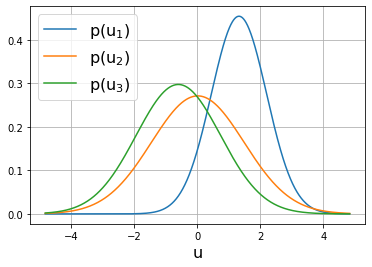

In [10]:
from scipy.stats import norm

mean=meanu[CA_te[0],0]
std_dev=np.sqrt(Sigmau[CA_te[0],CA_te[0]])
mean1=meanu[RA_te[0],0]
std_dev1=np.sqrt(Sigmau[RA_te[0],RA_te[0]])
xx = np.linspace(mean - 7*std_dev, mean + 4*std_dev, 1000)
# Calculate the corresponding y-axis values using the Gaussian PDF formula
yy = norm.pdf(xx, mean, std_dev)
yy1 = norm.pdf(xx, mean1, std_dev1)
# Plot the Gaussian PDF
plt.plot(xx, yy,color='C0',label="p(u$_1$)")
plt.plot(xx, yy1[:,0],color='C1',label="p(u$_2$)")
plt.plot(xx, yy1[:,1],color='C2',label="p(u$_3$)")
plt.xlabel('u',fontsize=16)
#plt.ylabel('Probability Density')
plt.legend(fontsize=16)
plt.grid(True)
plt.show()
#plt.savefig("modecanada_choice3.pdf")

In [28]:
yy1

array([[0.00268041, 0.00400115],
       [0.00273143, 0.00408216],
       [0.00278332, 0.00416461],
       ...,
       [0.00182275, 0.00015744],
       [0.00178724, 0.00015331],
       [0.00175236, 0.00014928]])

In [15]:
Sigmau[CA_te[0],CA_te[0]]

Array([0.69851636], dtype=float64)

In [26]:

# Large format
def make_large(df,num):
    dfl = df[df.noalt==num].copy()
    dfl['s']=dfl.groupby(['case']).cumcount()+1
    dfl=dfl.set_index(['s','case']).unstack(0)
    dfl.columns=[f"{x}{y}" for x,y in dfl.columns]
    dfl.drop(columns=["noalt"+str(i) for i in range(1,num+1)],inplace=True)
    return dfl.reset_index()
dfl = make_large(df,num)
cols=[]
for i in range(1,num+1):
    cols=cols+['dist'+str(i), 'cost'+str(i), 'ivt'+str(i), 'ovt'+str(i),'freq'+str(i)]
#dfl['target']=0*dfl['choice1']+1*dfl['choice2']+3*dfl['choice3']+2*dfl['choice4']
dfl[cols].duplicated(keep=False)

0       True
1       True
2       True
3       True
4      False
       ...  
147     True
148    False
149    False
150    False
151    False
Length: 152, dtype: bool

In [27]:
df

,case,alt,choice,dist,cost,ivt,ovt,freq,income,urban,noalt
424,139,train,1,354,59.00,237,69,4,35,1,4
425,139,air,0,354,155.80,56,97,9,35,1,4
426,139,bus,0,354,27.34,301,68,8,35,1,4
427,139,car,0,354,67.26,231,0,0,35,1,4
452,146,train,1,354,59.00,237,69,4,35,1,4
...,...,...,...,...,...,...,...,...,...,...,...
14551,4063,car,1,287,54.53,225,0,0,35,1,4
14572,4069,train,0,231,45.90,193,78,3,35,1,4
14573,4069,air,0,231,146.90,46,101,16,35,1,4
14574,4069,bus,0,231,25.21,186,81,24,35,1,4


In [28]:
df.shape

(608, 11)

In [29]:
len(CA_tr)+len(CA_te)

2037

In [30]:
cols=[]
for i in range(1,3):
    cols=cols+['dist'+str(i), 'cost'+str(i), 'ivt'+str(i), 'ovt'+str(i),'freq'+str(i)]
dfl = pd.DataFrame(columns=['case']+cols+['target'])
for c in np.unique(df.case.values):
    d = df[df.case==c]
    ind1=np.where(d.choice==1)[0]
    for i in np.setdiff1d(np.arange(num),ind1):
        if np.random.rand(1)<0.5:
            ii=ind1[0]
            jj=i
            t=1
        else:
            ii=i
            jj=ind1[0]
            t=0
        row=np.hstack([np.array([c]),d[cols_cov].iloc[ii].values,d[cols_cov].iloc[jj].values,np.array([t])])[None,:]
        dfl = pd.concat([dfl,pd.DataFrame(row,columns=dfl.columns)],axis=0)
    
dfl.reset_index(drop=True,inplace=True)
dfl

,case,dist1,cost1,ivt1,ovt1,freq1,dist2,cost2,ivt2,ovt2,freq2,target
0,139.0,354.0,155.80,56.0,97.0,9.0,354.0,59.00,237.0,69.0,4.0,0.0
1,139.0,354.0,27.34,301.0,68.0,8.0,354.0,59.00,237.0,69.0,4.0,0.0
2,139.0,354.0,67.26,231.0,0.0,0.0,354.0,59.00,237.0,69.0,4.0,0.0
3,146.0,354.0,59.00,237.0,69.0,4.0,354.0,155.80,56.0,97.0,9.0,1.0
4,146.0,354.0,59.00,237.0,69.0,4.0,354.0,27.34,301.0,68.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
451,4063.0,287.0,154.90,46.0,165.0,16.0,287.0,54.53,225.0,0.0,0.0,0.0
452,4063.0,287.0,20.86,115.0,95.0,8.0,287.0,54.53,225.0,0.0,0.0,0.0
453,4069.0,231.0,43.89,161.0,0.0,0.0,231.0,45.90,193.0,78.0,3.0,1.0
454,4069.0,231.0,43.89,161.0,0.0,0.0,231.0,146.90,46.0,101.0,16.0,1.0


In [25]:
dfl.shape

(2037, 12)

In [31]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier

In [32]:
splitter = GroupShuffleSplit(train_size=0.7, n_splits=n_splits, random_state = 1)
split = splitter.split(df, groups=df['case'])
Res=[]
for cv in range(n_splits):
    print(cv)
    ind_train, ind_test = next(split)
    
    dfl_train=dfl[dfl.case.isin(np.unique(df['case'].iloc[ind_train]))]
    dfl_test=dfl[dfl.case.isin(np.unique(df['case'].iloc[ind_test]))]
    Xl_train = dfl_train[cols].values
    yl_train=dfl_train['target'].values
    Xl_test = dfl_test[cols].values
    yl_test=dfl_test['target'].values

    scalerxl=StandardScaler().fit(Xl_train)
    Xl_train_trasf=scalerxl.transform(Xl_train)
    Xl_test_trasf=scalerxl.transform(Xl_test)
    
    eval_set = [(Xl_train_trasf, yl_train),(Xl_test_trasf, yl_test)]
    classif =  RandomForestClassifier(random_state=0) 
    classif.fit(Xl_train_trasf, yl_train) 
    ypred_x= classif.predict(Xl_test_trasf)
    Res.append(accuracy_score(ypred_x,yl_test)
    )

0
1
2
3
4


In [33]:
np.mean(Res)

0.881159420289855

In [34]:
Res

[0.9202898550724637,
 0.8405797101449275,
 0.927536231884058,
 0.8695652173913043,
 0.8478260869565217]

In [112]:
len(CA_tr)

1425

In [115]:
CA_tr

[[351],
 [352],
 [342],
 [342],
 [344],
 [344],
 [344],
 [344],
 [344],
 [344],
 [344],
 [343],
 [343],
 [343],
 [348],
 [348],
 [347],
 [347],
 [354],
 [354],
 [352],
 [318],
 [328],
 [328],
 [276],
 [275],
 [298],
 [299],
 [288],
 [288],
 [284],
 [152],
 [114],
 [115],
 [610],
 [641],
 [586],
 [560],
 [109],
 [102],
 [101],
 [101],
 [101],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [88],
 [90],
 [87],
 [87],
 [87],
 [87],
 [87],
 [87],
 [95],
 [93],
 [98],
 [98],
 [97],
 [624],
 [626],
 [626],
 [626],
 [626],
 [626],
 [626],
 [625],
 [638],
 [89],
 [89],
 [89],
 [6],
 [6],
 [33],
 [43],
 [26],
 [9],
 [505],
 [437],
 [437],
 [493],
 [493],
 [493],
 [493],
 [493],
 [493],
 [493],
 [493],
 [493],
 [493],
 [493],
 [492],
 [510],
 [510],
 [510],
 [510],
 [510],
 [509],
 [509],
 [518],
 [514],
 [514],
 [514],
 [514],
 [514],
 [514],
 [522],
 [37

In [114]:
RA_tr

[[350],
 [350],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [341],
 [345],
 [345],
 [345],
 [345],
 [349],
 [349],
 [349],
 [317],
 [325],
 [325],
 [274],
 [274],
 [297],
 [297],
 [286],
 [286],
 [282],
 [148],
 [112],
 [112],
 [607],
 [639],
 [583],
 [557],
 [108],
 [100],
 [100],
 [100],
 [100],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [85],
 [92],
 [92],
 [96],
 [96],
 [96],
 [623],
 [623],
 [623],
 [623],
 [623],
 [623],
 [623],
 [623],
 [635],
 [86],
 [86],
 [86],
 [4],
 [4],
 [35],
 [44],
 [24],
 [8],
 [503],
 [430],
 [430],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [488],
 [507],
 [507],
 [507],
 [507],
 [507],
 [507],
 [507],
 [515],
 [511],
 [511],
 [511],
 [511],
 [511],
 [511],
 [519],
 [37